# IMPORTS

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import scipy as sp
import statsmodels.formula.api as sm
from sklearn.inspection import permutation_importance
from itertools import product
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [52]:
# Preparando o Dataframe
df = pd.read_csv('DADOS CCNF.txt', delimiter='\t', decimal=',')
df = df.drop(columns=['#', 'Name'])
#display(df.to_string())
#df.astype({"Transmitancia":"int32"})
df["Transmitancia"][0]

78.721

In [53]:
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 14
DATASET_NAME = df
FEATURES = ["Concentracao", "Tamanho(x)", "Carga"]
TARGET = ["Transmitancia"]

indices = df.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

# observe que usamos o .values aqui pois queremos apenas os valores
X_treino = df_treino.reindex(FEATURES, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values
#print(y_treino)
X_teste = df_teste.reindex(FEATURES, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values

In [54]:
# alterando o formato do target
print(y_treino.shape, y_teste.shape)
y_treino = y_treino.ravel()
y_teste = y_teste.ravel()
print(y_treino.shape, y_teste.shape)

# cria o modelo
modelo_rf = RandomForestRegressor(random_state=SEMENTE_ALEATORIA)

# treina o modelo
modelo_rf.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_rf.predict(X_teste)
print()
print(previsao)

(171, 1) (19, 1)
(171,) (19,)

[21.59173405 33.8178301  18.55242584 16.14624026 66.19920779 40.22565771
 26.13963748 66.19920779 20.58005655 52.8892079  57.1806425  35.89745702
 73.25832881 90.66731064 49.04208538 16.14624026 62.71698209 20.67272081
 45.14843996]


# Checando a performance do nosso modelo de floresta aleatória.



In [55]:
from sklearn.metrics import mean_squared_error

y_verdadeiro = y_teste
y_previsao = modelo_rf.predict(X_teste)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo árvore de decisão foi de {RMSE}.")

O RMSE do modelo árvore de decisão foi de 10.704347785800728.


In [56]:
from sklearn.metrics import mean_squared_error

y_verdadeiro = y_treino
y_previsao = modelo_rf.predict(X_treino)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo árvore de decisão foi de {RMSE}.")

O RMSE do modelo árvore de decisão foi de 10.337761341493922.


In [65]:
NUM_ARVORES = [100, 300, 500]
NUM_FOLHAS = [None, 30]
NUM_PROFUNDIDADE = [None, 5]

for n_folhas, n_profundidade, n_arvores in product(
    NUM_FOLHAS, NUM_PROFUNDIDADE, NUM_ARVORES
):
    modelo_rf = RandomForestRegressor(
        n_estimators=n_arvores,
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        random_state=SEMENTE_ALEATORIA,
        n_jobs=4,
    )

    modelo_rf.fit(X_treino, y_treino)

    y_verdadeiro = y_teste
    y_previsao = modelo_rf.predict(X_teste)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

    print(
        f"O RMSE do modelo RF usando "
        f"n_estimators={n_arvores} max_leaf_nodes={n_folhas} "
        f"e max_depth={n_profundidade} foi de {RMSE:.2f}."
    )

O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=None e max_depth=None foi de 10.70.
O RMSE do modelo RF usando n_estimators=300 max_leaf_nodes=None e max_depth=None foi de 10.69.
O RMSE do modelo RF usando n_estimators=500 max_leaf_nodes=None e max_depth=None foi de 10.79.
O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=None e max_depth=5 foi de 11.36.
O RMSE do modelo RF usando n_estimators=300 max_leaf_nodes=None e max_depth=5 foi de 11.78.
O RMSE do modelo RF usando n_estimators=500 max_leaf_nodes=None e max_depth=5 foi de 11.71.
O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=30 e max_depth=None foi de 11.05.
O RMSE do modelo RF usando n_estimators=300 max_leaf_nodes=30 e max_depth=None foi de 11.05.
O RMSE do modelo RF usando n_estimators=500 max_leaf_nodes=30 e max_depth=None foi de 11.18.
O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=30 e max_depth=5 foi de 11.36.
O RMSE do modelo RF usando n_estimators=300 max_leaf_nodes=30 e max_de

# A importância das features usando o conceito de impureza


In [58]:
N_ARVORES = 50
N_JOBS = 4

modelo_rf = RandomForestRegressor(
    n_estimators=N_ARVORES,
    random_state=SEMENTE_ALEATORIA,
    n_jobs=N_JOBS,
)

modelo_rf.fit(X_treino, y_treino)

RandomForestRegressor(n_estimators=50, n_jobs=4, random_state=14)

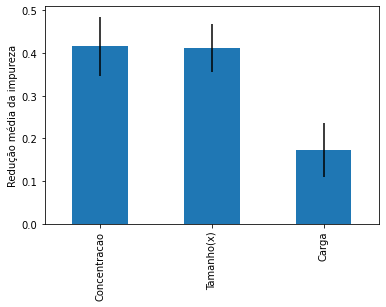

In [63]:
importancia = modelo_rf.feature_importances_
desvio_padrao = np.std(
    [arvore.feature_importances_ for arvore in modelo_rf.estimators_], axis=0
)

serie_importancia = pd.Series(importancia, index=FEATURES)

fig, axe = plt.subplots()
serie_importancia.plot.bar(yerr=desvio_padrao, ax=axe)
axe.set_ylabel("Redução média da impureza")
plt.show()

# Técnica de permutação de atributos



In [64]:
N_REPETICOES = 10


def R2_1param(modelo, x, y):
    """Computa o coef. de determinação quando hip. alt. não tem coef. linear."""
    y_pred = modelo.predict(x).ravel()
    y_true = (np.array(y)).ravel()
    return 1 - sum((y_true - y_pred) ** 2) / sum(y_true**2)


X_local = X_treino
y_local = y_treino

R2 = R2_1param(modelo_rf, X_local, y_local)
print(f"O R^2 da previsão é de {R2}")

# Aqui que calculamos a importância das features
r = permutation_importance(
    modelo_rf,
    X_local,
    y_local,
    n_repeats=N_REPETICOES,
    random_state=SEMENTE_ALEATORIA,
    scoring=R2_1param,
)

print()

# Aqui nós exibimos os resultados obtidos
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{FEATURES[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

O R^2 da previsão é de 0.9724741266774183

Concentracao0.371 +/- 0.024
Tamanho(x)0.264 +/- 0.024
Carga   0.109 +/- 0.018


# Determinando avaliando qual das features é a mais importante para a *generalização* do modelo.

In [61]:
X_local = X_teste
y_local = y_teste

R2 = R2_1param(modelo_rf, X_local, y_local)
print(f"O R^2 da previsão é de {R2}")

# Aqui que calculamos a importância das features
r = permutation_importance(
    modelo_rf,
    X_local,
    y_local,
    n_repeats=N_REPETICOES,
    random_state=SEMENTE_ALEATORIA,
    scoring=R2_1param,
)

print()

# Aqui nós exibimos os resultados obtidos
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{FEATURES[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

O R^2 da previsão é de 0.9488663639052228

Concentracao0.416 +/- 0.134
Tamanho(x)0.409 +/- 0.091


# Validação Cruzada

In [62]:

TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 14
DATASET_NAME = df
FEATURES = ["Concentracao", "Tamanho(x)", "Carga"]
TARGET = ["Transmitancia"]

indices = df.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

X_treino = df_treino.reindex(FEATURES, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values.ravel()
X_teste = df_teste.reindex(FEATURES, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values.ravel()

In [46]:
from itertools import product
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score


NUM_ARVORES = [10, 100, 300, 400, 500]
NUM_FOLHAS = [10, 20, 30, 40, 50]
NUM_PROFUNDIDADE = [1, 5, 10]
NUM_FOLDS = 10
NUM_CPU_CORES = 4

#NUM_ARVORES = [100, 300, 500]
#NUM_FOLHAS = [None, 30]
#NUM_PROFUNDIDADE = [None, 5]

for n_folhas, n_profundidade, n_arvores in product(
    NUM_FOLHAS, NUM_PROFUNDIDADE, NUM_ARVORES
):
    modelo_rf = RandomForestRegressor(
        n_estimators=n_arvores,
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        random_state=SEMENTE_ALEATORIA,
        n_jobs= NUM_CPU_CORES,
    )
    
    scores = cross_val_score(
    modelo_rf,
    X_treino,
    y_treino.ravel(),
    cv=NUM_FOLDS,
    )

    print("Aplicando a métrica de erro R² para os seguintes hiperparâmetros: \n"
        f"{n_arvores} número de árvores,\n"
        f"{n_folhas} número de folhas e\n"
        f"{n_profundidade} número de profundidade\n"
        f"temos que:\n"
        f"Os scores foram de: {scores}\n"
        f"A média dos scores é de: {scores.mean()}"
        f"\n"
    )
    

Aplicando a métrica de erro R² para os seguintes hiperparâmetros: 
10 número de árvores,
10 número de folhas e
1 número de profundidade
temos que:
Os scores foram de: [ 0.06836372  0.02921865  0.07183899  0.09324578  0.12517089  0.01645654
  0.05530321  0.42922914 -0.38944846  0.04642401]
A média dos scores é de: 0.05458024702081764

Aplicando a métrica de erro R² para os seguintes hiperparâmetros: 
100 número de árvores,
10 número de folhas e
1 número de profundidade
temos que:
Os scores foram de: [ 0.06680331  0.02146543  0.06274692  0.10270846  0.1019207  -0.02559441
  0.09272917  0.44880816 -0.37200389  0.04618522]
A média dos scores é de: 0.05457690637485414

Aplicando a métrica de erro R² para os seguintes hiperparâmetros: 
300 número de árvores,
10 número de folhas e
1 número de profundidade
temos que:
Os scores foram de: [ 0.06625363  0.02271526  0.06297849  0.10503557  0.10037297 -0.03670129
  0.10548732  0.4495254  -0.35882081  0.04195002]
A média dos scores é de: 0.055879656